# Surface Mass Balance 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

In [14]:
# Nils: Not needed??

from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set WD

In [3]:
import os
from pyrsistent import v
os.getcwd()
os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

**Load New Promice Data**

In [4]:
#Function for loading data and converting to datetime 
def load_promice(path_to_file):
    '''
    Loading PROMICE data for a given path into a DataFrame.
    + adding time index
    
    INTPUTS:
        path_to_file: Path to the desired file containing PROMICE data [string]
    
    OUTPUTS:
        df: Dataframe containing PROMICE data for the desired settings [DataFrame]
    '''

    df = pd.read_parquet(path_to_file, engine='pyarrow')
    df['time'] = pd.to_datetime(df.time, utc=True)
    df = df.set_index('time')
    return df




In [5]:
df = load_promice('data/new_promice/all_promice_data_hourly.parquet.gzip')

#### Load KM_L 

In [6]:
df = pd.read_csv('data/KAN_L.csv')

# add headers
header = pd.read_csv('metadata/promice_header.csv', sep = ";")
df = df.rename(columns = header.set_index('standard_name')['long_name'])

In [97]:
# Visual check on the usefulness of t the Ice Ablation periods

#....

In [7]:
# This bit to only focus on the time where we see Ice Ablation
df = df[df["Ablation"] == True]

**Helper functions** (Nils: Can be removed?) 

In [8]:
#Function for writing to Markdown Report
def Msg(txt):
    f = open("out/Report.md", "a")
    print(txt)
    f.write(txt + "\n")

In [9]:
#For outlier detecttion and filter 
def hampel(vals_orig, k=7*24, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    outlier_idx[0:round(k/2)]=False
    vals.loc[outlier_idx]=np.nan
    return(vals)

#### Correlation and Pairplot (takes long time to run for many variables)

In [10]:
df.columns

Index([                                        'index',
                                                'stid',
                                        'air_pressure',
                                     'air_temperature',
                                   'relative_humidity',
                         'relative_humidity_corrected',
                                   'specific_humidity',
                                          'wind_speed',
                                 'wind_from_direction',
                  'surface_downwelling_shortwave_flux',
        'surface_downwelling_shortwave_flux_corrected',
                    'surface_upwelling_shortwave_flux',
          'surface_upwelling_shortwave_flux_corrected',
                                      'surface_albedo',
                   'surface_downwelling_longwave_flux',
                     'surface_upwelling_longwave_flux',
                                 'cloud_area_fraction',
                                 'surface_temper

In [11]:
# This bit to plot only relevant columns
exclude_list = ["stid", "index", "Datetime", 'index',
                                                'stid',
                                   'relative_humidity',
                                   'specific_humidity',
                                 'wind_from_direction',
                  'surface_downwelling_shortwave_flux',
                    'surface_upwelling_shortwave_flux',
                   'surface_downwelling_longwave_flux',
                     'surface_upwelling_longwave_flux',
                   'surface_downward_latent_heat_flux',
                 'surface_downward_sensible_heat_flux',
                       'distance_to_surface_from_boom',
             'distance_to_surface_from_stake_assembly',
                 'depth_of_pressure_transducer_in_ice',
       'depth_of_pressure_transducer_in_ice_corrected',
                                       'precipitation',
                               'ice_temperature_at_t1',
                               'ice_temperature_at_t2',
                               'ice_temperature_at_t3',
                               'ice_temperature_at_t4',
                               'ice_temperature_at_t5',
                               'ice_temperature_at_t6',
                               'ice_temperature_at_t7',
                               'ice_temperature_at_t8',
                               'platform_view_angle_x',
                               'platform_view_angle_y',
                              'platform_azimuth_angle',
                                        'gps_latitude',
                                       'gps_longitude',
                                        'gps_altitude',
                                            'gps_time',
                                'gps_geoid_separation',
                                         'gps_geounit',
                                            'gps_hdop',
                                          'gps_numsat',
                                               'gps_q',
                                     'battery_voltage',
                     'battery_voltage_at_sample_start',
                                         'fan_current',
           'frequency_of_precipitation_wire_vibration',
                               'temperature_of_logger',
                     'temperature_of_radiation_sensor',
                # no entries for KAM_L
                                   'z_surf_1_adj_flag', 
                               'ice_temperature_at_t9',
                              'ice_temperature_at_t10',
                              'ice_temperature_at_t11',
                         'depth_of_ice_temperature_t9',
                        'depth_of_ice_temperature_t10',
                        'depth_of_ice_temperature_t11', 
               
               ]

exclude = df[[column for column in df.columns if column not in exclude_list and not isinstance(column, int)]]
exclude = exclude.dropna(axis=1,how='all') 

<ipython-input-30-b29c7c3f52c3>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
<ipython-input-30-b29c7c3f52c3>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


<AxesSubplot:>

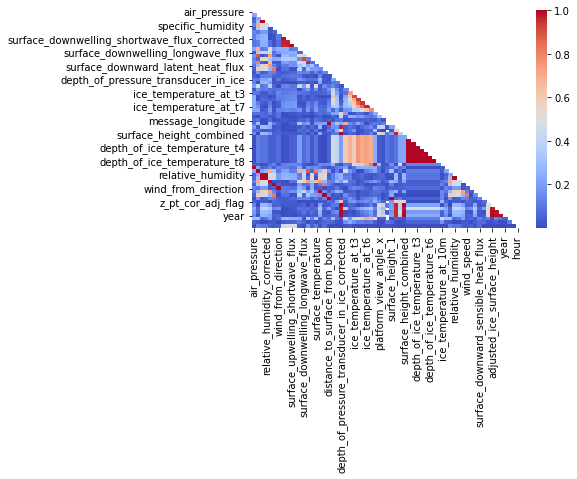

In [30]:
#sns.pairplot(data= exclude, hue="Ablation")
#sns.pairplot(data = exclude, kind='reg')

# Plot correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find the index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Generate a mask for the lower triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap of correlated columns
sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask)

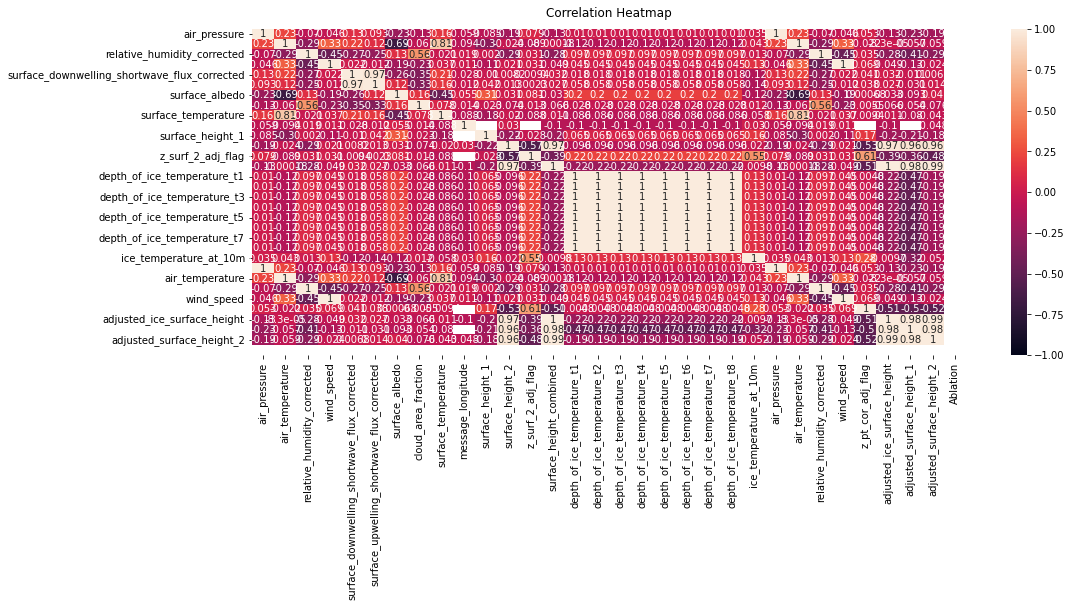

In [16]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(exclude.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Modelling

##### Pre-processing

In [18]:
# Change Ablation to binary
#df['Ablation'].replace(False, 0,inplace=True)
#df['Ablation'].replace(True, 1, inplace=True)

# A list of columns that are not considered relevant
exclude_list = [
                        "Ablation", # Since we only consider Ice Ablation periods anyways
                        'index', # Not needed
                        "stid", # Not needed for one Station
                        ## The following are not useful ##
                        'platform_azimuth_angle',
                        'gps_latitude',
                        'gps_longitude',
                        'gps_altitude',
                        'gps_time',
                        'gps_geoid_separation',
                        'gps_geounit',
                        'gps_hdop',
                        'gps_numsat',
                        'gps_q',
                        'battery_voltage',
                        'battery_voltage_at_sample_start',
                        'fan_current',
                        'frequency_of_precipitation_wire_vibration',
                        'temperature_of_logger',
                        'temperature_of_radiation_sensor',
                        ## The following have no entries for KAM_L ##
                        'z_surf_1_adj_flag', 
                        'ice_temperature_at_t9',
                        'ice_temperature_at_t10',
                        'ice_temperature_at_t11',
                        'depth_of_ice_temperature_t9',
                        'depth_of_ice_temperature_t10',
                        'depth_of_ice_temperature_t11', 
          ]

df = df[[column for column in df.columns if column not in exclude_list]]
df = df.dropna(axis=1,how='all') 

In [19]:
# This bit to change all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler

num_cols = df.select_dtypes(include=['int64','float64']).columns #select numerical columns

scaler = StandardScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [20]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

# Use CyclicalFeatures for the conversion
from feature_engine.creation import CyclicalFeatures

date_cols = df[['year', 'month','day', 'hour']].columns

# Create cyclical features
cyc_feat = CyclicalFeatures(drop_original=True)

#fit and transform numerical columns
df[date_cols] = scaler.fit_transform(df[date_cols])

In [21]:
df.columns

Index(['air_pressure', 'air_temperature', 'relative_humidity',
       'relative_humidity_corrected', 'specific_humidity', 'wind_speed',
       'wind_from_direction', 'surface_downwelling_shortwave_flux',
       'surface_downwelling_shortwave_flux_corrected',
       'surface_upwelling_shortwave_flux',
       'surface_upwelling_shortwave_flux_corrected', 'surface_albedo',
       'surface_downwelling_longwave_flux', 'surface_upwelling_longwave_flux',
       'cloud_area_fraction', 'surface_temperature',
       'surface_downward_latent_heat_flux',
       'surface_downward_sensible_heat_flux', 'distance_to_surface_from_boom',
       'distance_to_surface_from_stake_assembly',
       'depth_of_pressure_transducer_in_ice',
       'depth_of_pressure_transducer_in_ice_corrected',
       'ice_temperature_at_t1', 'ice_temperature_at_t2',
       'ice_temperature_at_t3', 'ice_temperature_at_t4',
       'ice_temperature_at_t5', 'ice_temperature_at_t6',
       'ice_temperature_at_t7', 'ice_temperature_

In [22]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

X= df.loc[:, df.columns != 'surface_height_combined'] # All features except y
y=df['surface_height_combined']

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

**PCA**

------------------------- With Imputation -----------------------------------------------------------------

In [23]:
# PCA does not allow missing values, we need to impute or exclude all NAN values..

# import the KNNimputer class
from sklearn.impute import KNNImputer

# create an object for KNNImputer
imputer = KNNImputer(n_neighbors = 2)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.fit_transform(X_test)

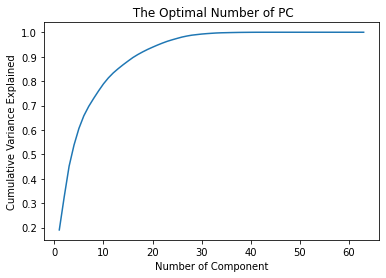

ValueError: Shape of passed values is (5, 63), indices imply (2, 64)

In [24]:
# Apply PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train_imp = pca.fit_transform(X_train_imp)
X_test_imp = pca.transform(X_test_imp)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()

#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.6) + 1

#Transform data with the optimal number of components
pca = PCA(n_components=optimal_component)
X_train_imp = pca.fit_transform(X_train_imp)
X_test_imp = pca.transform(X_test_imp)

# see how much features contribute to which components
pca_df = pd.DataFrame(pca.components_,
                        columns=df.columns,
                       index = ['PC-1','PC-2'])
pca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
sns.heatmap(pca_df,cmap ='magma')
plt.title('Feature Importance')
plt.show()

-------------------------------- Without Imputation ---------------------------------------------------

In [44]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/ymcdull/ppca

# With PPca



ImportError: cannot import name 'probabilistic_pca' from 'sklearn.decomposition' (/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/__init__.py)

In [46]:
# import necessary libraries 
import pandas as pd
from sklearn.decomposition import ProbabilisticPCA
import matplotlib.pyplot as plt


# train the PPCA model 
# specifying n_components as 0.99 to account for the missing values, to retain 99% of the variance of the original dataset
pca = ProbabilisticPCA(n_components=0.99, missing_values='NaN')
X_reduced = pca.fit_transform(X)

# extract components 
eigenvalues = pca.eigenvalues_
components = pca.components_

# visualize the results 

ImportError: cannot import name 'ProbabilisticPCA' from 'sklearn.decomposition' (/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/__init__.py)

PCA With all variables

In [47]:
#importing relevant libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import mixture

# Conducting Probabilistic Principal Component Analysis
ppca = mixture.BayesianGaussianMixture(n_components = 2, covariance_type = "full", tol = 0.0001, max_iter = 500).fit(X)

# Extracting the Proabaility distribution 
x_mean = ppca.means_ 
x_var = ppca.covariances_


ValueError: Input X contains NaN.
BayesianGaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Multivariate Regression**

In [45]:
#import linear regression model from scikit-learn library
from sklearn.linear_model import LinearRegression

#import libraries for visualization
import matplotlib as mp


#instantiate the LinearRegression model 
lm = LinearRegression()

#fit the model to our data
lm.fit(X,y)

#obtain the coefficients 
coefficients = pd.DataFrame({'Coefficient':lm.coef_[0]}, index=X.columns)

#visualize the coefficients 
plt.figure(figsize=(20,5))
sns.barplot(x=coefficients.index, y="Coefficient",data=coefficients,
            color="c")
plt.xticks

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values